# 4.2. Classifying Newswires: A Multi-class Classification Examples

# 4.2.1: The Reuters Dataset
- About: A set of short newswires and their topics for text classification. There are 46 different topics and some topics are more represented than others, but each topic has at least 10 examples in a training dataset.
- Similar to IMDB Dataset, we restrict data to the 10k most frequently occurring words found in data

In [1]:
# import library
import numpy as np
import matplotlib.pyplot as plt
import copy

# import tensorflow
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# load the dataset
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2121728/2110848 [==============================] - 1s 0us/step


In [3]:
print(len(train_data))
print(len(test_data))

8982
2246


In [4]:
# check sample
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [5]:
# Decoding news back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]]) 
print(decoded_newswire)

565248/550378 [==============================] - 0s 1us/step
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


# 4.2.2. Data Processing

In [6]:
def vectorize_sequences(sequences, dimension=10000):
    # create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    
    # go thru each sequence, then go thru each encoded words, the make it 1
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [7]:
# encode input data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Note**: as this is multiclass label, there are differnt ways to do it: one-hot encoding with categorical encoding.

In [8]:
# way 1: manually do it
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [9]:
# way 2: use keras
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

# 4.2.3. Modeling
- In Dense layer, each layer can only access info present in the output of the previous layer. If one layer drops some info relevant to the classification problem, this info can't be recovered from the later layers. Thus, we make the Dense layer "thicker" so that the info bottleneck is larger and can let more info go thru.
- **Note**: The output of the model is a probability distribution with a 46-dimensional output vector where output[i] is the probability that the sample belongs to class i. The total is 1 for that output.

In [10]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax"), 
])

2023-02-04 04:45:28.308056: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


**Note**: As we use a multiclass classification, we will use a categorical_crossentropy loss function. This loss function measures the distance between two probability distribution (by the model and by the true distribution of the label).

In [11]:
# compile model
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# 4.2.4. Validate Model
- Set the first 1000 sample in the training dataset as validation and train the rest of the training dataset.

In [12]:
# set up dataset
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [13]:
# train the model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

2023-02-04 04:45:29.138511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
16/16 [==============================] - 1s 43ms/step - loss: 2.6348 - accuracy: 0.5328 - val_loss: 1.7213 - val_accuracy: 0.6590
Epoch 2/20
16/16 [==============================] - 0s 24ms/step - loss: 1.4133 - accuracy: 0.7146 - val_loss: 1.2853 - val_accuracy: 0.7200
Epoch 3/20
16/16 [==============================] - 0s 23ms/step - loss: 1.0321 - accuracy: 0.7799 - val_loss: 1.1131 - val_accuracy: 0.7650
Epoch 4/20
16/16 [==============================] - 0s 24ms/step - loss: 0.8077 - accuracy: 0.8290 - val_loss: 1.0084 - val_accuracy: 0.7850
Epoch 5/20
16/16 [==============================] - 0s 23ms/step - loss: 0.6405 - accuracy: 0.8685 - val_loss: 0.9400 - val_accuracy: 0.8050
Epoch 6/20
16/16 [==============================] - 0s 23ms/step - loss: 0.5073 - accuracy: 0.8970 - val_loss: 0.9170 - val_accuracy: 0.8080
Epoch 7/20
16/16 [==============================] - 0s 27ms/step - loss: 0.4104 - accuracy: 0.9151 - val_loss: 0.8927 - val_accuracy: 0.8060
Epoch 8/20
16

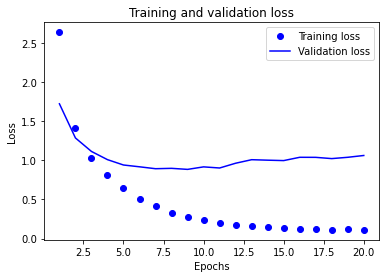

In [14]:
# plot loss history
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

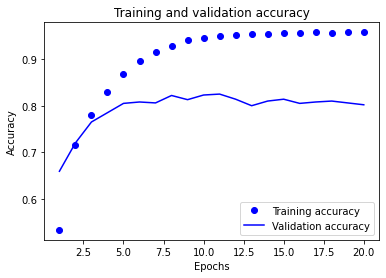

In [15]:
# plot accuracy history
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
# retrain model from scratch with full dataset
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax"), 
])

model.compile(optimizer="rmsprop",
 loss="categorical_crossentropy",
 metrics=["accuracy"])

model.fit(x_train,
 y_train,
 epochs=9,
 batch_size=512)

results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 24ms/step - loss: 2.4790 - accuracy: 0.5160
Epoch 2/9
18/18 [==============================] - 0s 20ms/step - loss: 1.3266 - accuracy: 0.7135
Epoch 3/9
18/18 [==============================] - 0s 20ms/step - loss: 0.9664 - accuracy: 0.7910
Epoch 4/9
18/18 [==============================] - 0s 20ms/step - loss: 0.7469 - accuracy: 0.8432
Epoch 5/9
18/18 [==============================] - 0s 20ms/step - loss: 0.5865 - accuracy: 0.8795
Epoch 6/9
18/18 [==============================] - 0s 20ms/step - loss: 0.4663 - accuracy: 0.9019
Epoch 7/9
18/18 [==============================] - 0s 20ms/step - loss: 0.3702 - accuracy: 0.9215
Epoch 8/9
18/18 [==============================] - 0s 20ms/step - loss: 0.3048 - accuracy: 0.9343
Epoch 9/9
71/71 [==============================] - 0s 2ms/step - loss: 0.9727 - accuracy: 0.7903


In [17]:
results

[0.9726559519767761, 0.7902938723564148]

**Note**: the accuracy is ~80%.

## Tips On Model Performance Compared To Baseline Model
- For a binary classification, a random classifier will get ~50%. What about for 46 classes and they may NOT be equally represented. What would the accuracy baseline model?

In [18]:
# make a copy of label
test_labels_copy = copy.copy(test_labels)

# randomly shuffle it
np.random.shuffle(test_labels_copy)

# check how many match we got after shuffle
hits_array = np.array(test_labels) == np.array(test_labels_copy)

# print out mean
print(hits_array.mean())

0.18477292965271594


**Note**: We can see that a random classifier would score around 19% accuracy. Thus our model is very good!

# 4.2.5. Generate Predictions On New Data

In [19]:
predictions = model.predict(x_test)

In [20]:
print(predictions)

[[6.4510918e-05 2.7403477e-04 2.0648049e-05 ... 3.7233505e-05
  6.5949953e-06 3.0163239e-06]
 [3.6020167e-04 4.8286710e-03 3.2632828e-03 ... 1.3939608e-04
  3.9741784e-07 6.8779525e-05]
 [1.5669499e-03 8.0627412e-01 4.8169185e-04 ... 4.5125873e-04
  1.4921208e-04 3.3804262e-03]
 ...
 [2.2858230e-05 1.2263369e-04 1.3748193e-05 ... 4.3990672e-06
  5.4672560e-06 1.1922723e-06]
 [6.3783783e-03 4.4687938e-02 1.6979099e-03 ... 1.2604481e-03
  1.5387520e-04 6.7569176e-04]
 [7.5021232e-03 2.6893982e-01 2.7520235e-03 ... 2.2254803e-04
  2.3580546e-04 4.4199947e-04]]


In [21]:
# check shape
predictions[0].shape

(46,)

In [22]:
# proof that the total prediction is 1
print(np.sum(predictions[0]))

1.0000002


In [23]:
# print the largest predicted class's index
print(np.argmax(predictions[0]))

# print shape
print(predictions[0].shape)

# print the output of the first prediction
print(predictions[0])

# print the probability of the largest predicted class
print(predictions[0][3])

3
(46,)
[6.4510918e-05 2.7403477e-04 2.0648049e-05 9.1382450e-01 6.7984447e-02
 5.8439791e-06 2.0073294e-05 1.0411578e-04 8.0271233e-03 9.1653877e-05
 3.1853608e-05 1.0878787e-03 4.5451041e-05 2.9718861e-04 2.2230808e-05
 2.5616668e-04 8.9263992e-04 1.9204259e-05 1.1112310e-04 6.1568280e-04
 2.6229131e-03 1.9637760e-04 7.1687605e-06 2.1399120e-04 1.4809477e-05
 4.7044046e-05 1.6721945e-06 2.3356942e-04 4.4421522e-06 1.8050689e-04
 8.0772872e-05 1.3026518e-04 1.3400809e-04 2.1811920e-06 1.6520765e-04
 7.5311720e-05 1.8643848e-04 9.5569940e-06 1.5216535e-04 1.5973375e-03
 6.5939617e-05 1.7521483e-05 1.7743327e-05 3.7233505e-05 6.5949953e-06
 3.0163239e-06]
0.9138245
